# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from ratelimit import limits
import time
import json
import seaborn as sns

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

645

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).

> **HINT:** The OpenWeatherMap API only allows 60 calls per minute under their free plan. Try using `time.sleep(60)` after each set of 50 cities to avoid API errors due to large calls.

In [3]:
# Setup API Calling
# url
url = "http://api.openweathermap.org/data/2.5/weather?"
# url = "https://openweathermap.org/api"

# units
unit = "units=Imperial"

# api
api = "&APPID=" + weather_api_key

# response 
response = requests.get( url + unit + api).json()

# print statement
print(response)

# Storage for api call data
city_info = {"City": [], 
             "Lat": [], 
             "Lng": [],
             "Max Temp": [],
             "Humidity": [],
             "Cloudiness": [],
             "Wind Speed": [],
             "Country": [], 
             "Date": []}

# hint, limit api calls
minute = 60
@limits(calls=60, period=minute)

# api call loop
def call_api():
    
    for i, city in enumerate(cities):
        city = requests.get(url + unit + "&q=" + cities[i] + api).json()
        
        try:
            print("Processing city " + str(i) + ": " + city["name"])
        
            city_info["City"].append(city["name"])
            city_info["Lat"].append(city["coord"]["lat"])
            city_info["Lng"].append(city["coord"]["lon"])
            city_info["Max Temp"].append(city["main"]["temp_max"])
            city_info["Humidity"].append(city["main"]["humidity"])
            city_info["Cloudiness"].append(city["clouds"]["all"])
            city_info["Wind Speed"].append(city["wind"]["speed"])
            city_info["Country"].append(city["sys"]["country"])
            city_info["Date"].append(city["dt"])
            
        except:
            print("Incomplete..., skip over missing city info.")
            pass
    print("Complete")
    
call_api()


            
            
        

{'cod': '400', 'message': 'Nothing to geocode'}
Processing city 0: Puerto Madryn
Incomplete..., skip over missing city info.
Processing city 2: Busselton
Processing city 3: Mitzic
Processing city 4: Kaitangata
Processing city 5: George Town
Incomplete..., skip over missing city info.
Processing city 7: Mossamedes
Processing city 8: Revelstoke
Processing city 9: Athabasca
Processing city 10: Kirakira
Processing city 11: Bredasdorp
Processing city 12: Bluff
Processing city 13: Ushuaia
Processing city 14: Tazovsky
Processing city 15: Madimba
Processing city 16: Pevek
Processing city 17: Uberaba
Processing city 18: Anito
Processing city 19: Fort Nelson
Incomplete..., skip over missing city info.
Processing city 21: Albany
Processing city 22: Beyneu
Processing city 23: Flinders
Processing city 24: Ahipara
Processing city 25: Clyde River
Processing city 26: Ayan
Processing city 27: Pustoshka
Processing city 28: Batagay-Alyta
Processing city 29: Meulaboh
Processing city 30: Rikitea
Processing

Processing city 264: Hukuntsi
Processing city 265: Rincón de la Victoria
Processing city 266: Khani
Processing city 267: Nyzhni Sirohozy
Processing city 268: Tougan
Processing city 269: Port Blair
Processing city 270: Atocha
Processing city 271: Lujiang
Processing city 272: Victor Harbor
Processing city 273: Ushtobe
Processing city 274: Cootamundra
Processing city 275: Belize
Processing city 276: Huarmey
Processing city 277: Agadez
Processing city 278: Springbok
Processing city 279: Villazón
Processing city 280: Jalu
Processing city 281: Yangi Marg`ilon
Processing city 282: Ketchikan
Processing city 283: Pundaguitan
Processing city 284: Isangel
Processing city 285: Hohhot
Processing city 286: Baykit
Processing city 287: Oktyabr'skiy
Incomplete..., skip over missing city info.
Processing city 289: Safaga
Processing city 290: Vila Velha
Processing city 291: Lagos
Processing city 292: Nelson Bay
Incomplete..., skip over missing city info.
Processing city 294: Auki
Processing city 295: Dep

Processing city 528: Plettenberg Bay
Processing city 529: Jining
Processing city 530: Labytnangi
Processing city 531: Yurino
Processing city 532: Sciacca
Processing city 533: Pontianak
Processing city 534: Corrientes
Processing city 535: Malko Tarnovo
Processing city 536: Ninghai
Processing city 537: Maragogi
Processing city 538: Bartica
Processing city 539: Fortuna
Processing city 540: Algiers
Processing city 541: Marsá Maţrūḩ
Processing city 542: Matara
Processing city 543: Olavarría
Processing city 544: São Filipe
Processing city 545: Rome
Processing city 546: Araceli
Processing city 547: Beloha
Processing city 548: Sechura
Processing city 549: Nouadhibou
Processing city 550: Jardim
Processing city 551: Katsuura
Processing city 552: Champerico
Processing city 553: Djibouti
Processing city 554: Puerto Escondido
Processing city 555: Tura
Processing city 556: Qaqortoq
Processing city 557: Bhainsdehi
Processing city 558: Barreirinha
Processing city 559: Lere
Processing city 560: Tarko-S

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
# Creating DataFrame
city_info_df = pd.DataFrame(city_info)

# Clean DataFrame
city_info_df["Max Temp"] = city_info_df["Max Temp"].replace('', np.nan)
city_info_df = city_info_df.dropna()

# Export as CSV file
city_info_df.to_csv(output_data_file, index_label="City_ID")

In [5]:
# Inspect DataFrame
city_info_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Puerto Madryn,-42.7692,-65.0385,66.34,46,4,16.84,AR,1644192149
1,Busselton,-33.6500,115.3333,61.09,61,70,18.79,AU,1644192149
2,Mitzic,0.7821,11.5490,71.02,80,40,3.27,GA,1644192150
3,Kaitangata,-46.2817,169.8464,58.93,76,6,6.22,NZ,1644191878
4,George Town,5.4112,100.3354,76.95,97,40,3.00,MY,1644191993
...,...,...,...,...,...,...,...,...,...
598,Yongchang,30.0381,119.7317,34.57,100,100,5.19,CN,1644192362
599,Fenoarivo,-18.9330,47.4354,66.27,94,40,3.44,MG,1644192362
600,Mayen,50.3333,7.2167,39.69,90,100,17.98,DE,1644192363
601,Tigzirt,36.8886,4.1198,51.42,83,8,1.88,DZ,1644192363


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
# Table Columns
lat = city_info_df["Lat"]
max_temp = city_info_df["Max Temp"]
humidity = city_info_df["Humidity"]
cloudiness = city_info_df["Cloudiness"]
wind_speed = city_info_df["Wind Speed"]

In [7]:
#  Get the indices of cities that have humidity over 100%.
city_info_df["Humidity"]

0       46
1       61
2       80
3       76
4       97
      ... 
598    100
599     94
600     90
601     83
602     80
Name: Humidity, Length: 603, dtype: int64

C:\Users\chris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Humidity'>

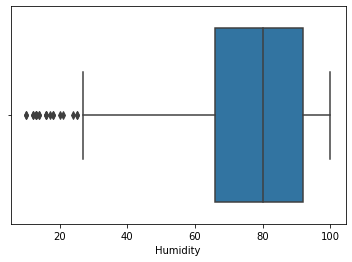

In [8]:
# Couldn't figure out how to use plot_filtered to fix FutureWarning
sns.boxplot(city_info_df["Humidity"])



In [9]:
# Print Outlier (if one exists)
print(np.where(city_info_df["Humidity"] > 100))
# Array is empty, no 'Humidity' over 100% exists in current dataset.

(array([], dtype=int64),)


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

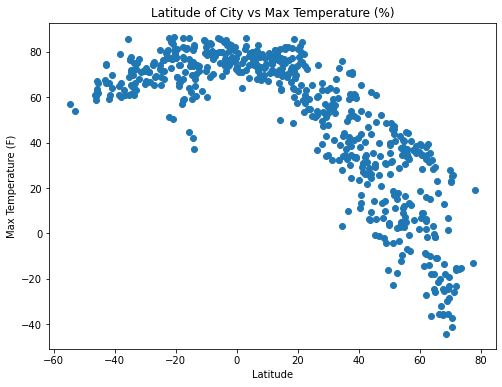

In [20]:
# Latitude vs Temperature
# viz config
plt.figure(figsize=(8,6))
lat_vs_temp = plt.scatter(lat, max_temp, linewidths=1, marker="o")


# titles & labels
plt.title("Latitude of City vs Max Temperature (%)")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
# Display Plot
plt.show()

In [17]:
# Save fig
lat_vs_temp.get_figure().savefig("../Images/Fig1.png")

## Latitude vs. Humidity Plot

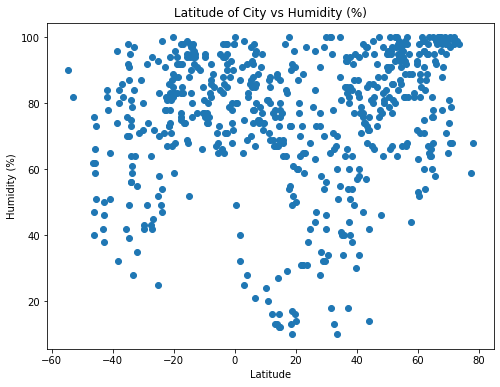

In [18]:
# Latitude vs Humidity
# viz config
plt.figure(figsize=(8,6))
lat_vs_humidity = plt.scatter(lat, humidity, linewidths=1, marker="o")

# titles & labels
plt.title("Latitude of City vs Humidity (%)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# Display Plot
plt.show()

In [19]:
lat_vs_humidity.get_figure().savefig("../Images/Fig2.png")

## Latitude vs. Cloudiness Plot

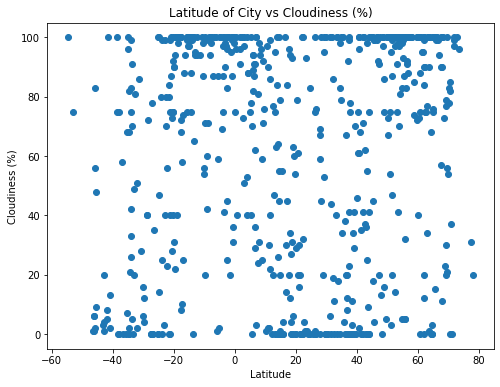

In [21]:
# Latitude vs Cloudiness
# viz config
plt.figure(figsize=(8,6))
lat_vs_cloudiness = plt.scatter(lat, cloudiness, linewidths=1, marker="o")

# titles & labels
plt.title("Latitude of City vs Cloudiness (%)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
# Display Plot
plt.show()

In [22]:
lat_vs_cloudiness.get_figure().savefig("../Images/Fig3.png")

## Latitude vs. Wind Speed Plot

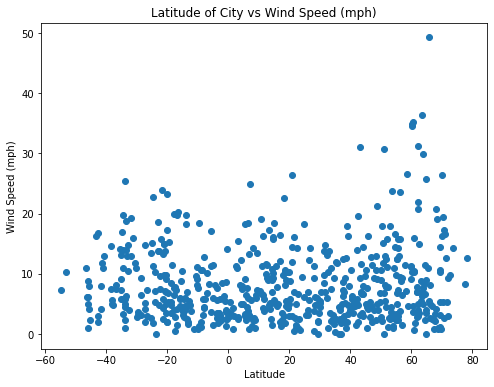

In [23]:
# Latitude vs Cloudiness
# viz config
plt.figure(figsize=(8,6))
lat_vs_wind_speed = plt.scatter(lat, wind_speed, linewidths=1, marker="o")

# titles & labels
plt.title("Latitude of City vs Wind Speed (mph)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
# Display Plot
plt.show()

In [24]:
lat_vs_wind_speed.get_figure().savefig("../Images/Fig4.png")

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression